<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>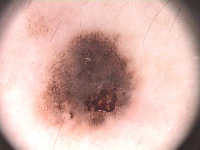</td><td>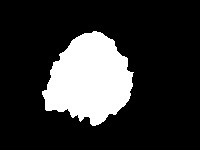</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [79]:
import gc
import time

In [3]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [5]:
min_h = min_w = min_c = 1000
for image in images:
    min_h = min(min_h, image.shape[0])
    min_w = min(min_w, image.shape[1])
    min_c = min(min_c, image.shape[2])
min_h, min_w, min_c
# (577, 769, 3)
# (553, 761, 3)

(553, 761, 3)

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [6]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [7]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

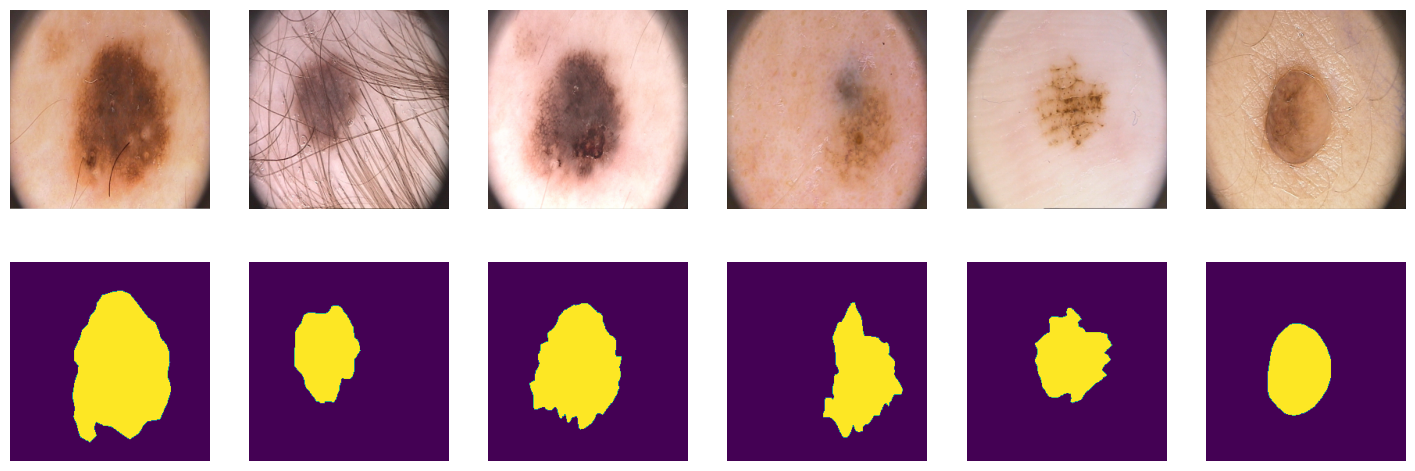

In [123]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [130]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [131]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [132]:
from torch.utils.data import DataLoader
batch_size = 10
# np.rollaxis(X[tr], 3, 1) - изменение размерности c HWC на CHW
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [12]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

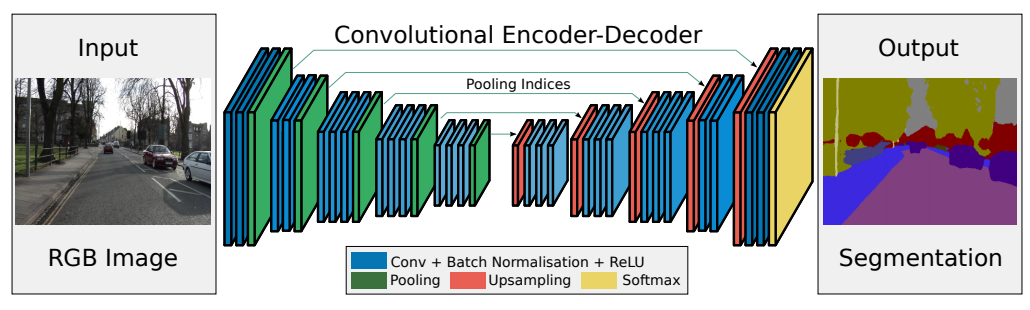

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim


from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [23]:
class SegNet(nn.Module):
    def __init__(self,channels_size=64):
        super().__init__()
        
        # Параметр return_indices - если True то вернет максимальные индексы вместе с выходными данными. 
        # Нужно для nn.MaxUnpool2d, чтобы при восстановлении (unsampling) расставлять значения в нужные позиции 
        self.max_pool = nn.MaxPool2d(kernel_size=2, return_indices = True) # 256 -> 128
        
        self.enc_conv0 = nn.Sequential(
                            nn.Conv2d(in_channels=3, out_channels=channels_size, kernel_size=3, padding=1),
                            nn.ReLU(),
                            nn.BatchNorm2d(channels_size),
            
                            nn.Conv2d(in_channels=channels_size, out_channels=channels_size, kernel_size=3, padding=1),
                            nn.ReLU(),
                            nn.BatchNorm2d(channels_size),
                            
                        )
        self.max_pool0 = nn.MaxPool2d(kernel_size=2, return_indices = True) # 256 -> 128
        
        self.enc_conv1 = nn.Sequential(
                            nn.Conv2d(in_channels=channels_size, out_channels=channels_size*2, kernel_size=3, padding=1),
                            nn.ReLU(),
                            nn.BatchNorm2d(channels_size*2),
            
                            nn.Conv2d(in_channels=channels_size*2, out_channels=channels_size*2, kernel_size=3, padding=1),
                            nn.ReLU(),
                            nn.BatchNorm2d(channels_size*2),
                        )
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, return_indices = True) # 256 -> 128
        
        self.enc_conv2 = nn.Sequential(
                            nn.Conv2d(in_channels=channels_size*2, out_channels=channels_size*4, kernel_size=3, padding=1),
                            nn.ReLU(),
                            nn.BatchNorm2d(channels_size*4),
            
                            nn.Conv2d(in_channels=channels_size*4, out_channels=channels_size*4, kernel_size=3, padding=1),
                            nn.ReLU(),
                            nn.BatchNorm2d(channels_size*4),
            
                            nn.Conv2d(in_channels=channels_size*4, out_channels=channels_size*4, kernel_size=3, padding=1),
                            nn.ReLU(),
                            nn.BatchNorm2d(channels_size*4),
                        )
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, return_indices = True) # 256 -> 128
        
        self.enc_conv3 = nn.Sequential(
                            nn.Conv2d(in_channels=channels_size*4, out_channels=channels_size*8, kernel_size=3, padding=1),
                            nn.ReLU(),
                            nn.BatchNorm2d(channels_size*8),
            
                            nn.Conv2d(in_channels=channels_size*8, out_channels=channels_size*8, kernel_size=3, padding=1),
                            nn.ReLU(),
                            nn.BatchNorm2d(channels_size*8),  
            
                            nn.Conv2d(in_channels=channels_size*8, out_channels=channels_size*8, kernel_size=3, padding=1),
                            nn.ReLU(),
                            nn.BatchNorm2d(channels_size*8),
                        )
        self.max_pool3 = nn.MaxPool2d(kernel_size=2, return_indices = True) # 256 -> 128
        
        self.bottleneck = nn.Sequential(
                            nn.Conv2d(in_channels=channels_size*8, out_channels=channels_size*16, kernel_size=3, padding=1),
                            nn.BatchNorm2d(channels_size*16),
                            nn.ReLU(),
            
                            nn.Conv2d(in_channels=channels_size*16, out_channels=channels_size*8, kernel_size=3, padding=1),
                            nn.BatchNorm2d(channels_size*8),  
                            nn.ReLU(),
                        )

        # decoder (upsampling)
        self.unmax_pool = nn.MaxUnpool2d(kernel_size=2)
        self.unmax_pool3 = nn.MaxUnpool2d(kernel_size=2)
        self.upsample3 = nn.Sequential(
                            nn.Conv2d(in_channels=channels_size*8, out_channels=channels_size*4, kernel_size=3, padding=1),
                            nn.BatchNorm2d(channels_size*4),
                            nn.ReLU(),
            
                            nn.Conv2d(in_channels=channels_size*4, out_channels=channels_size*4, kernel_size=3, padding=1),
                            nn.BatchNorm2d(channels_size*4),  
                            nn.ReLU(),
            
                            nn.Conv2d(in_channels=channels_size*4, out_channels=channels_size*4, kernel_size=3, padding=1),
                            nn.BatchNorm2d(channels_size*4),
                            nn.ReLU(),
                        )
    
        self.unmax_pool2 = nn.MaxUnpool2d(kernel_size=2)
        self.upsample2 = nn.Sequential(
#                             nn.MaxUnpool2d(kernel_size=2) # 32 -> 64
            
                            nn.Conv2d(in_channels=channels_size*4, out_channels=channels_size*2, kernel_size=3, padding=1),
                            nn.BatchNorm2d(channels_size*2),
                            nn.ReLU(),
            
                            nn.Conv2d(in_channels=channels_size*2, out_channels=channels_size*2, kernel_size=3, padding=1),
                            nn.BatchNorm2d(channels_size*2),  
                            nn.ReLU(),
            
                            nn.Conv2d(in_channels=channels_size*2, out_channels=channels_size*2, kernel_size=3, padding=1),
                            nn.BatchNorm2d(channels_size*2),
                            nn.ReLU(),
                        )
        
        self.unmax_pool1 = nn.MaxUnpool2d(kernel_size=2)
        self.upsample1 = nn.Sequential(
                            nn.Conv2d(in_channels=channels_size*2, out_channels=channels_size, kernel_size=3, padding=1),
                            nn.BatchNorm2d(channels_size),
                            nn.ReLU(),
            
                            nn.Conv2d(in_channels=channels_size, out_channels=channels_size, kernel_size=3, padding=1),
                            nn.BatchNorm2d(channels_size),  
                            nn.ReLU(),
            
                        )
        
        self.unmax_pool0 = nn.MaxUnpool2d(kernel_size=2)
        self.upsample0 = nn.Sequential(
                            nn.Conv2d(in_channels=channels_size, out_channels=1, kernel_size=3, padding=1),
                            nn.BatchNorm2d(1),
                            nn.ReLU(),
            
                            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1),
                        )
        
    def forward(self, x):
        # encoder
        encoder0, ind_max0 = self.max_pool0(self.enc_conv0(x))
        encoder1, ind_max1 = self.max_pool1(self.enc_conv1(encoder0))
        encoder2, ind_max2 = self.max_pool2(self.enc_conv2(encoder1))
        encoder3, ind_max3 = self.max_pool3(self.enc_conv3(encoder2))
        bottle_neck = self.bottleneck(encoder3)
        decoder3 = self.upsample3(self.unmax_pool3(bottle_neck, ind_max3))
        decoder2 = self.upsample2(self.unmax_pool2(decoder3, ind_max2))
        decoder1 = self.upsample1(self.unmax_pool1(decoder2, ind_max1))
        decoder0 = self.upsample0(self.unmax_pool0(decoder1, ind_max0))
        
        return decoder0

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [25]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [26]:
def bce_loss(y_real, y_pred):
    # Если использовать Numpy методы np.log и np.exp то необходимо переводить тензоры из gpu в cpu
    #loss = y_pred - y_real*y_pred + np.log(1+np.exp(-y_pred))
    loss = y_pred - y_pred*y_real + torch.log(1+torch.exp(-y_pred)) + 1e-7 #x - x * z + log(1 + exp(-x))
    return loss.sum()  

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [137]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):

    history = []
    best_score = 0
    best_state_model = model.state_dict().copy()
    
    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))
        
        # train mode
        train_loss = 0
        model.train()  
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            
            # set parameter gradients to zero
            opt.zero_grad()
            
            Y_pred = model(X_batch) # forward
            loss = loss_fn(y_real=Y_batch, y_pred=Y_pred) # calc loss
            loss.backward()  # backward-pass
            opt.step()  # update weights
            train_loss += loss
        # calculate train loss
        train_loss = train_loss / len(data_tr)
        

        # testing mode
        val_loss = 0
        model.eval()  
        for X_val, Y_val in data_val:
            with torch.set_grad_enabled(False):
                Y_hat = model(X_val.to(device)).detach().cpu()
                loss = loss_fn(y_real=Y_val, y_pred=Y_hat) 
                val_loss += loss
        # calculate val loss
        val_loss = val_loss / len(data_val)

        show_X_val, show_Y_val = next(iter(data_val))
        # calc Y_pred to user show
        show_Y_hat = model(show_X_val.to(device)).detach().cpu()
        
        # calculate score train/val
        score_train = score_model(model, iou_pytorch, data_tr)
        score_val = score_model(model, iou_pytorch, data_val)
        if score_val > best_score:
            best_score = score_val
            best_state_model = model.state_dict().copy()
        
        # Visualize tools
        clear_output(wait=True)
        plt.figure(figsize=(15, 9))        
        for k in range(5):
            plt.subplot(3, 5, k+1)
            plt.imshow(np.rollaxis(show_X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 5, k+6)
            plt.imshow(show_Y_hat[k, 0], cmap='gray')
            plt.title('Output Pred')
            plt.axis('off')

            plt.subplot(3, 5, k+11)
            plt.imshow(show_Y_val[k, 0], cmap='gray')
            plt.title('True Target')
            plt.axis('off')
            
        plt.suptitle(f"epoch: {epoch+1}/{epochs}, loss_train: {torch.round(train_loss, decimals=4)}, val_loss: {torch.round(val_loss, decimals=4)}, score: score_train: {round(score_train,4)}, score_val: {round(score_val,4)}")
        plt.show()
        history.append((train_loss.detach().cpu(), val_loss, score_train, score_val))
        
    return history
        

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [44]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [47]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        # Надо в Y_pred прийти к 1/0  
        Y_pred = torch.where(Y_pred > 0.01, 1, 0)
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

In [109]:
# Высвобождаем память на GPU

# del model
def clear_memory():
    # kill PID_Number
    # Высвобождаем память на GPU
    
    for _ in range(3):
        time.sleep(2)
        torch.cuda.empty_cache()
        gc.collect()
    # !nvidia-smi

    # torch.cuda.empty_cache()
    # gc.collect()
    # # torch.cuda.memory_summary(device=None, abbreviated=False)
clear_memory()    
torch.cuda.empty_cache()
gc.collect()
!nvidia-smi

Sun Apr 23 11:26:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 42%   65C    P8    13W / 151W |   2402MiB /  4096MiB |     12%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


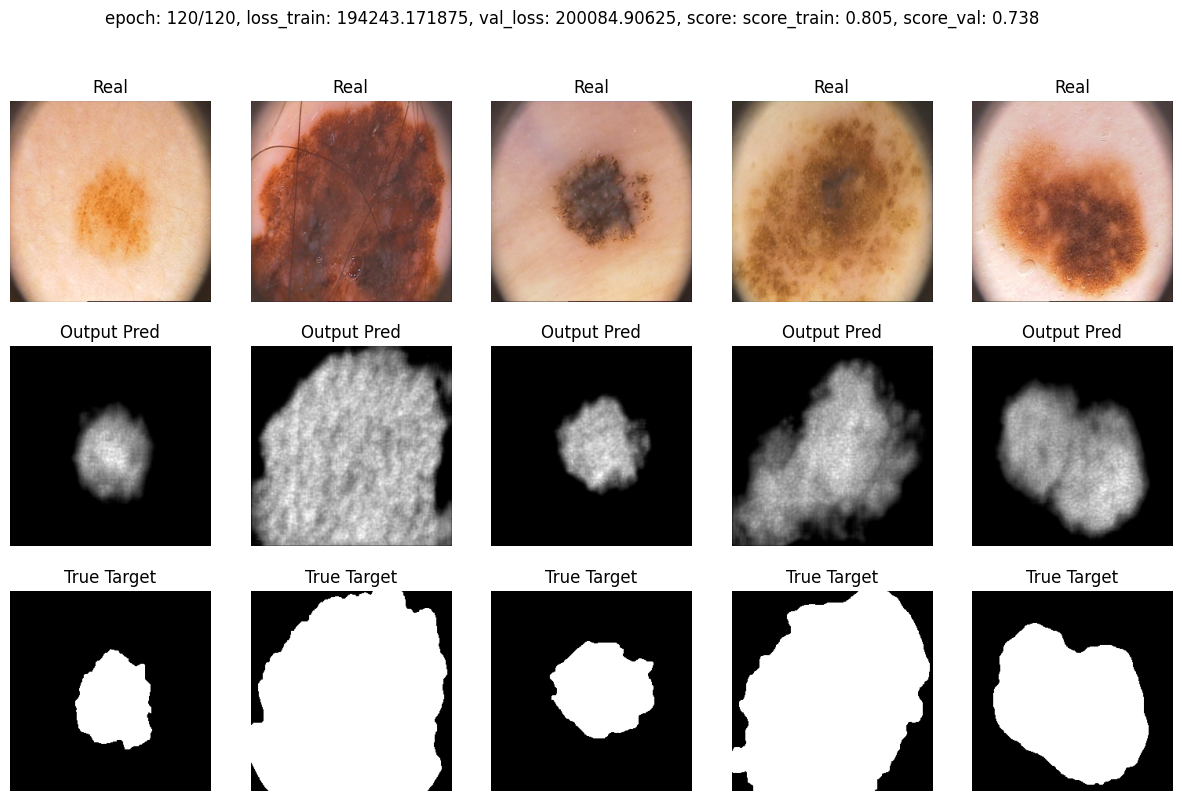

Score by Val Data: 0.7380000352859497
Score by Test Data: 0.7440000176429749


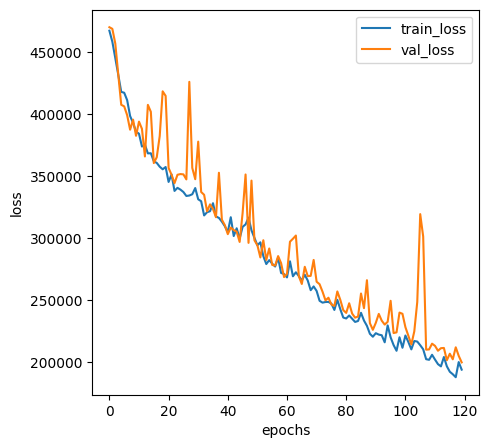

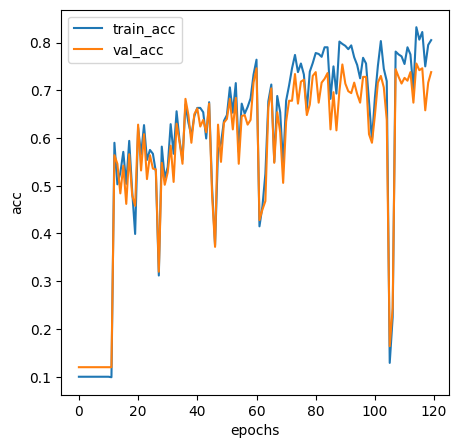

In [159]:
# BCE 120 эпох - Val 73% Test 74%
model = SegNet().to(device)

max_epochs = 120
optimaizer = optim.Adam(model.parameters())
history = train(model, optimaizer, bce_loss, max_epochs, data_tr, data_val)

score_data_val = score_model(model, iou_pytorch, data_val)
print(f"Score by Val Data: {score_data_val}")
score_data_ts = score_model(model, iou_pytorch, data_ts)
print(f"Score by Test Data: {score_data_ts}")

loss, val_loss, acc, val_acc = zip(*history)
plt.figure(figsize=(5, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


plt.figure(figsize=(5, 5))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

Ответьте себе на вопрос: не переобучается ли моя модель?

Судя по результатам score и loss модель не переобучается даже при исползовании 120 эпох

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [112]:
def dice_loss(y_pred,y_real):
    # eps нужен как защита от крайних значений. например если и y_pred = 0 и y_real = 0
    eps = 1e-8
    # Тензор переводим в одномерный через флаттен
    # Дополнительно Так как у нас вывод прогнозной сегментации одного класса по сути от 0 до 1 то 
    # можем ограничивать выход сигмоидой, это приведет выход в диапозон от 0 до 1 и 
    # также избавит отрицательных значений
    pred = torch.flatten(torch.sigmoid(y_pred))
    real = torch.flatten(y_real)
    num = 2.*(pred*real).sum() + eps
    den =  pred.sum() + real.sum() + eps
    return 1 - (1/256*256) * (num)/(den)


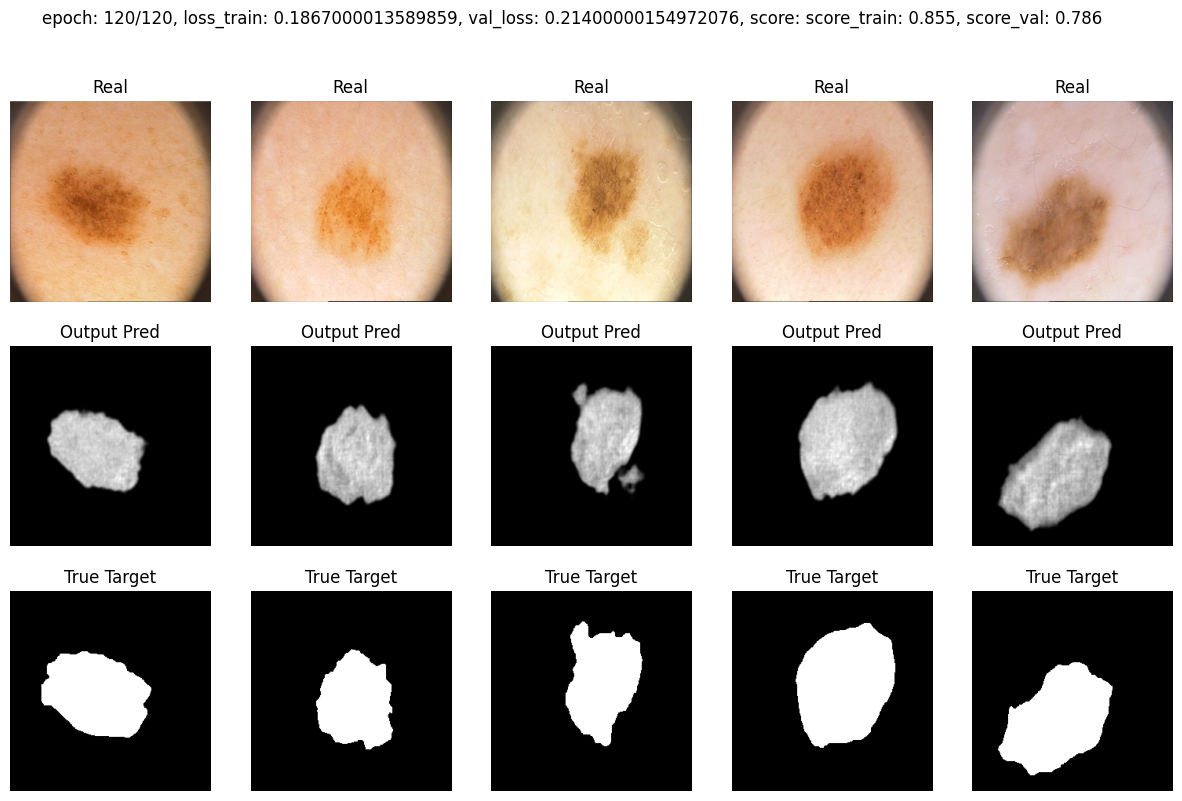

Score by Val Data: 0.7860000252723693
Score by Test Data: 0.7760000109672547


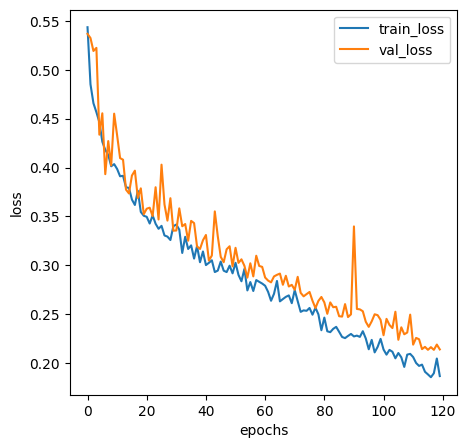

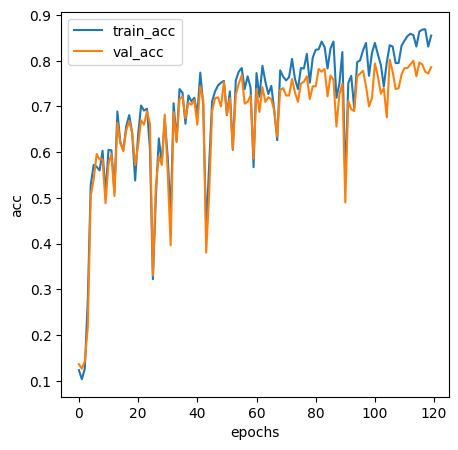

In [155]:
# dice_loss 120 эпох- Val 78% Test 77%
model = SegNet().to(device)

max_epochs = 120
optimaizer = optim.Adam(model.parameters())
history = train(model, optimaizer, dice_loss, max_epochs, data_tr, data_val)

score_data_val = score_model(model, iou_pytorch, data_val)
print(f"Score by Val Data: {score_data_val}")
score_data_ts = score_model(model, iou_pytorch, data_ts)
print(f"Score by Test Data: {score_data_ts}")

loss, val_loss, acc, val_acc = zip(*history)
plt.figure(figsize=(5, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


plt.figure(figsize=(5, 5))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()



[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [115]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    # eps нужен как защита от крайних значений. например если и y_pred = 0 и y_real = 0
    eps = 1e-8
    # Тензор переводим в одномерный через флаттен
    # Дополнительно Так как у нас вывод прогнозной сегментации одного класса по сути от 0 до 1 то 
    # можем ограничивать выход сигмоидой, это приведет выход в диапозон от 0 до 1 и 
    # также избавит отрицательных значений
    pred = torch.flatten(torch.sigmoid(y_pred))
    real = torch.flatten(y_real)
    part_1 = ((1 - pred + eps)**gamma)
    part_2 = real*torch.log(pred + eps) 
    part_3 = (1-real)*torch.log(1 - pred + eps)
    focal = -(part_1*part_2 + part_3).sum()
    return focal


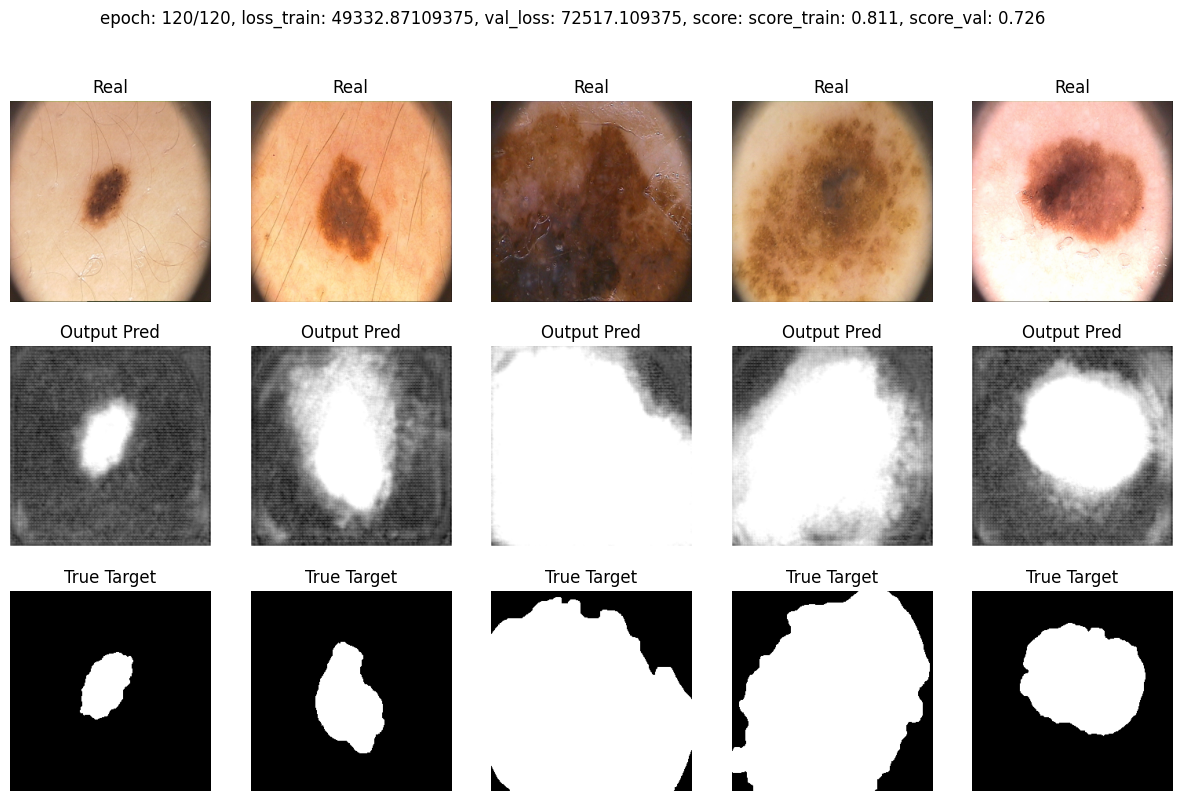

Score by Val Data: 0.7260000348091126
Score by Test Data: 0.7180000424385071


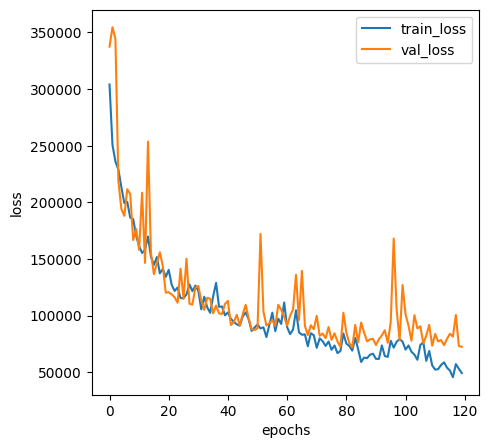

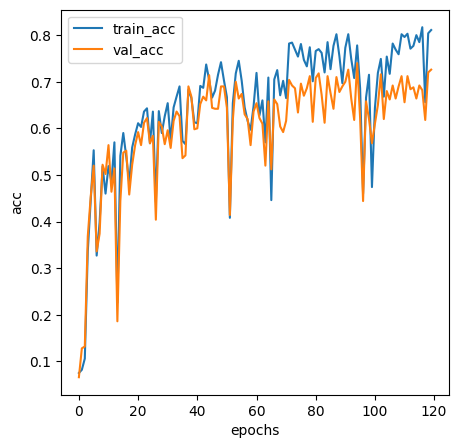

In [160]:
# focal_loss 120 эпох- 72%
model = SegNet().to(device)

max_epochs = 120
optimaizer = optim.Adam(model.parameters())
history = train(model, optimaizer, focal_loss, max_epochs, data_tr, data_val)

score_data_val = score_model(model, iou_pytorch, data_val)
print(f"Score by Val Data: {score_data_val}")
score_data_ts = score_model(model, iou_pytorch, data_ts)
print(f"Score by Test Data: {score_data_ts}")

loss, val_loss, acc, val_acc = zip(*history)
plt.figure(figsize=(5, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


plt.figure(figsize=(5, 5))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

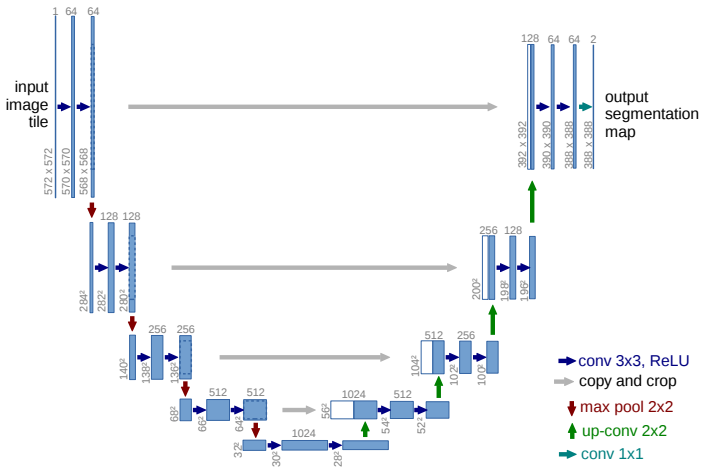

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [120]:
class UNet(nn.Module):
    def __init__(self, channels_size=64):
        super().__init__()
        # Размер channels_size, по умолчанию стоит 64, но учитывая 
        # ограничение размера видеопамяти можем уменьшать его при инициализации модели
        self.max_pool = nn.MaxPool2d(kernel_size=2) 
        
        self.enc_conv0 = nn.Sequential(
                            nn.Conv2d(in_channels=3, out_channels=channels_size, kernel_size=3, padding=1),
                            nn.ReLU(),
                            nn.BatchNorm2d(channels_size),
            
                            nn.Conv2d(in_channels=channels_size, out_channels=channels_size, kernel_size=3, padding=1),
                            nn.ReLU(),
                            nn.BatchNorm2d(channels_size),
                            
                        )   
        self.enc_conv1 = nn.Sequential(
                            nn.Conv2d(in_channels=channels_size, out_channels=channels_size*2, kernel_size=3, padding=1),
                            nn.ReLU(),
                            nn.BatchNorm2d(channels_size*2),
            
                            nn.Conv2d(in_channels=channels_size*2, out_channels=channels_size*2, kernel_size=3, padding=1),
                            nn.ReLU(),
                            nn.BatchNorm2d(channels_size*2),
                            
                        )    
        self.enc_conv2 = nn.Sequential(
                            nn.Conv2d(in_channels=channels_size*2, out_channels=channels_size*4, kernel_size=3, padding=1),
                            nn.ReLU(),
                            nn.BatchNorm2d(channels_size*4),
            
                            nn.Conv2d(in_channels=channels_size*4, out_channels=channels_size*4, kernel_size=3, padding=1),
                            nn.ReLU(),
                            nn.BatchNorm2d(channels_size*4),
                            
                        )   
        self.enc_conv3 = nn.Sequential(
                            nn.Conv2d(in_channels=channels_size*4, out_channels=channels_size*8, kernel_size=3, padding=1),
                            nn.ReLU(),
                            nn.BatchNorm2d(channels_size*8),
            
                            nn.Conv2d(in_channels=channels_size*8, out_channels=channels_size*8, kernel_size=3, padding=1),
                            nn.ReLU(),
                            nn.BatchNorm2d(channels_size*8),
                            
                        )   

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
                            nn.Conv2d(in_channels=channels_size*8, out_channels=channels_size*16, kernel_size=1, padding=0),
                            nn.BatchNorm2d(channels_size*16),
                            nn.ReLU(),
            
                            nn.Conv2d(in_channels=channels_size*16, out_channels=channels_size*8, kernel_size=1, padding=0),
                            nn.BatchNorm2d(channels_size*8),  
                            nn.ReLU(),
                        )        

        # decoder (upsampling)
        self.upsample =  nn.UpsamplingBilinear2d(scale_factor=2) 
        self.dec_conv0 = nn.Sequential(
                            nn.Conv2d(in_channels=channels_size*8*2, out_channels=channels_size*4*2, kernel_size=3, padding=1),
                            nn.BatchNorm2d(channels_size*4*2),
                            nn.ReLU(),
            
                            nn.Conv2d(in_channels=channels_size*4*2, out_channels=channels_size*4, kernel_size=3, padding=1),
                            nn.BatchNorm2d(channels_size*4),  
                            nn.ReLU(),
                        )        
        self.dec_conv1 = nn.Sequential(
                            nn.Conv2d(in_channels=channels_size*4*2, out_channels=channels_size*2*2, kernel_size=3, padding=1),
                            nn.BatchNorm2d(channels_size*2*2),
                            nn.ReLU(),
            
                            nn.Conv2d(in_channels=channels_size*2*2, out_channels=channels_size*2, kernel_size=3, padding=1),
                            nn.BatchNorm2d(channels_size*2),  
                            nn.ReLU(),
                        )      
        self.dec_conv2 = nn.Sequential(
                            nn.Conv2d(in_channels=channels_size*2*2, out_channels=channels_size*2, kernel_size=3, padding=1),
                            nn.BatchNorm2d(channels_size*2),
                            nn.ReLU(),
            
                            nn.Conv2d(in_channels=channels_size*2, out_channels=channels_size, kernel_size=3, padding=1),
                            nn.BatchNorm2d(channels_size),  
                            nn.ReLU(),
                        )      
        self.dec_conv3 = nn.Sequential(
                            nn.Conv2d(in_channels=channels_size*2, out_channels=channels_size, kernel_size=3, padding=1),
                            nn.BatchNorm2d(channels_size),
                            nn.ReLU(),

                            nn.Conv2d(in_channels=channels_size, out_channels=channels_size, kernel_size=3, padding=1),
                            nn.BatchNorm2d(channels_size),
                            nn.ReLU(),
            
                            nn.Conv2d(in_channels=channels_size, out_channels=1, kernel_size=3, padding=1),
                        )   
    def forward(self, x):
        # encoder
        encoder0 = self.enc_conv0(x)
        max_pool_0 = self.max_pool(encoder0)
        
        encoder1 = self.enc_conv1(max_pool_0)
        max_pool_1 = self.max_pool(encoder1)
        
        encoder2 = self.enc_conv2(max_pool_1)
        max_pool_2 = self.max_pool(encoder2)
        
        encoder3 = self.enc_conv3(max_pool_2)
        max_pool_3 = self.max_pool(encoder3)

        # bottleneck
        bottle_neck = self.bottleneck_conv(max_pool_3)
        # decoder
        # Формируем объединеный вход. Важно складываются именно каналы, поэтому используется ось 1
        ext_bottle_neck = torch.cat([encoder3, self.upsample(bottle_neck)], 1)
        d0 = self.dec_conv0(ext_bottle_neck)
        
        ext_d0  = torch.cat([encoder2, self.upsample(d0)], 1)
        d1 = self.dec_conv1(ext_d0)

        ext_d1  = torch.cat([encoder1, self.upsample(d1)], 1)
        d2 = self.dec_conv2(ext_d1)

        ext_d2  = torch.cat([encoder0, self.upsample(d2)], 1)
        d3 = self.dec_conv3(ext_d2)
        return d3

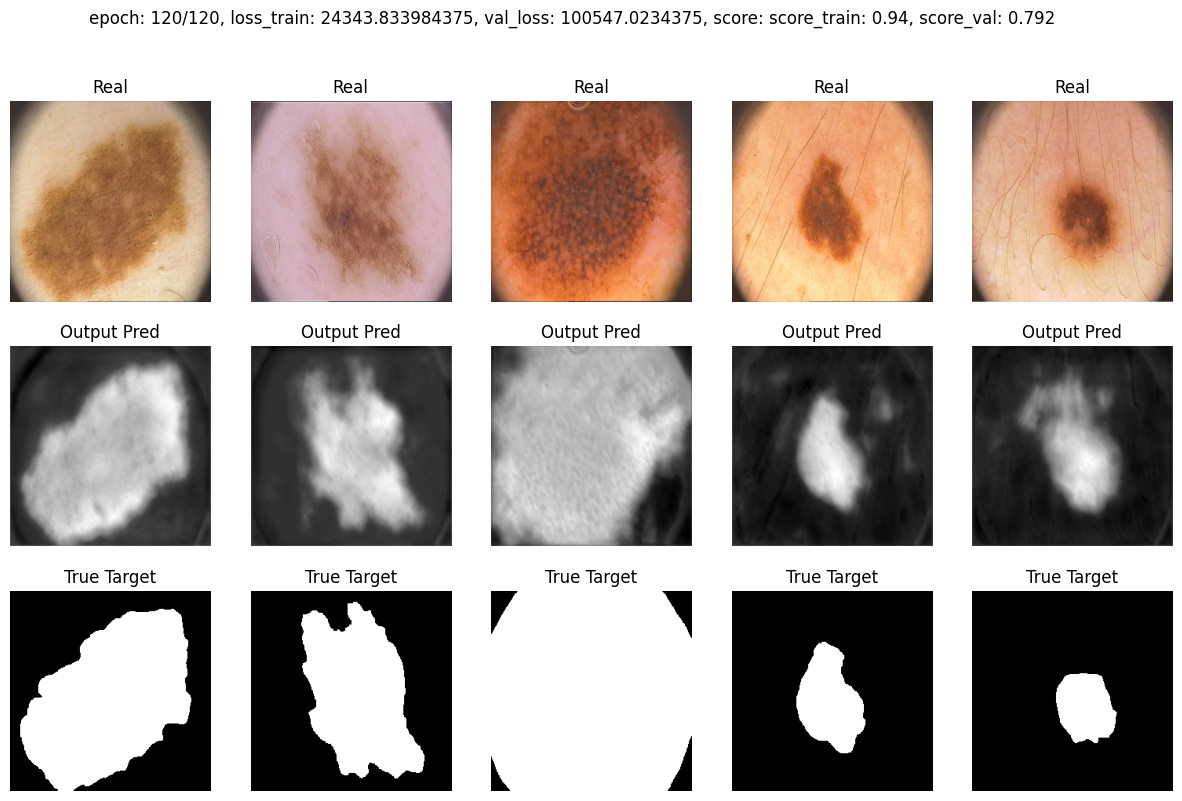

Score by Val Data: 0.7920000076293945
Score by Test Data: 0.7300000190734863


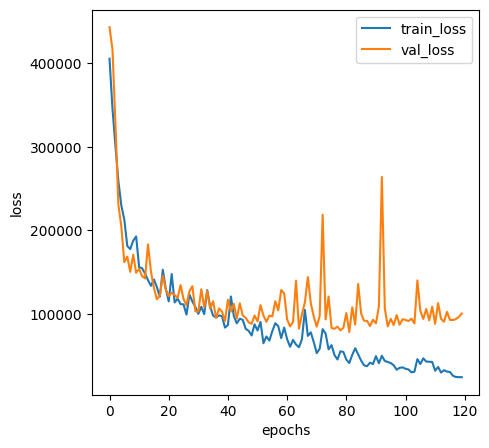

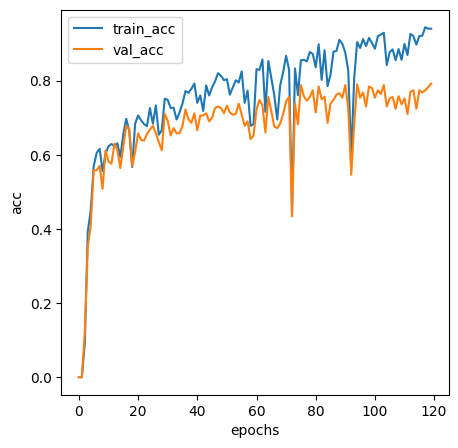

In [161]:
# UNet + Upsampling + bce_loss 120 эпох- 78% размер feature-map вместо 64 всего 8, из-за нехватки памяти видеокарты
model = UNet(channels_size=8).to(device)

max_epochs = 120
optimaizer = optim.Adam(model.parameters())
history = train(model, optimaizer, bce_loss, max_epochs, data_tr, data_val)

score_data_val = score_model(model, iou_pytorch, data_val)
print(f"Score by Val Data: {score_data_val}")
score_data_ts = score_model(model, iou_pytorch, data_ts)
print(f"Score by Test Data: {score_data_ts}")

loss, val_loss, acc, val_acc = zip(*history)
plt.figure(figsize=(5, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


plt.figure(figsize=(5, 5))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

### UNET Dice loss

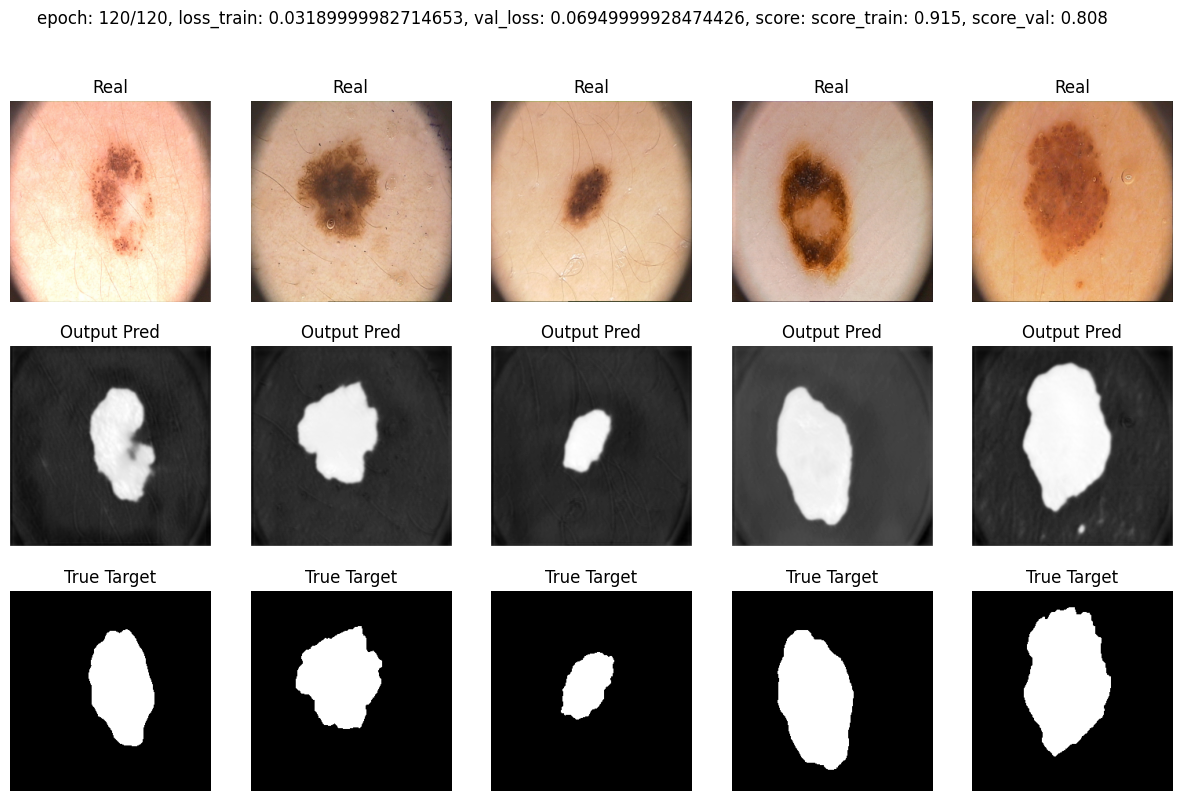

Score by Val Data: 0.8080000162124634
Score by Test Data: 0.7540000319480896


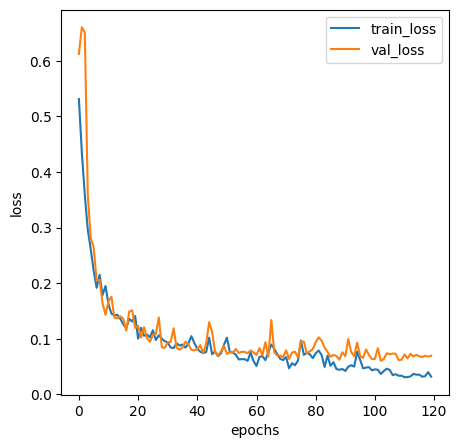

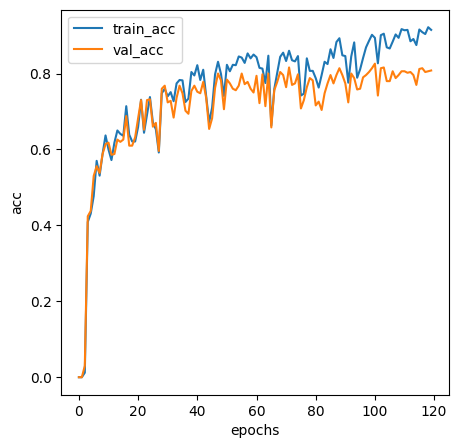

In [164]:
# UNet + Upsampling + dice_loss 120 эпох- 76% размер feature-map вместо 64 всего 8, из-за нехватки памяти видеокарты
model = UNet(channels_size=8).to(device)

max_epochs = 120
optimaizer = optim.Adam(model.parameters())
history = train(model, optimaizer, dice_loss, max_epochs, data_tr, data_val)

score_data_val = score_model(model, iou_pytorch, data_val)
print(f"Score by Val Data: {score_data_val}")
score_data_ts = score_model(model, iou_pytorch, data_ts)
print(f"Score by Test Data: {score_data_ts}")

loss, val_loss, acc, val_acc = zip(*history)
plt.figure(figsize=(5, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


plt.figure(figsize=(5, 5))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

### UNET Focal loss


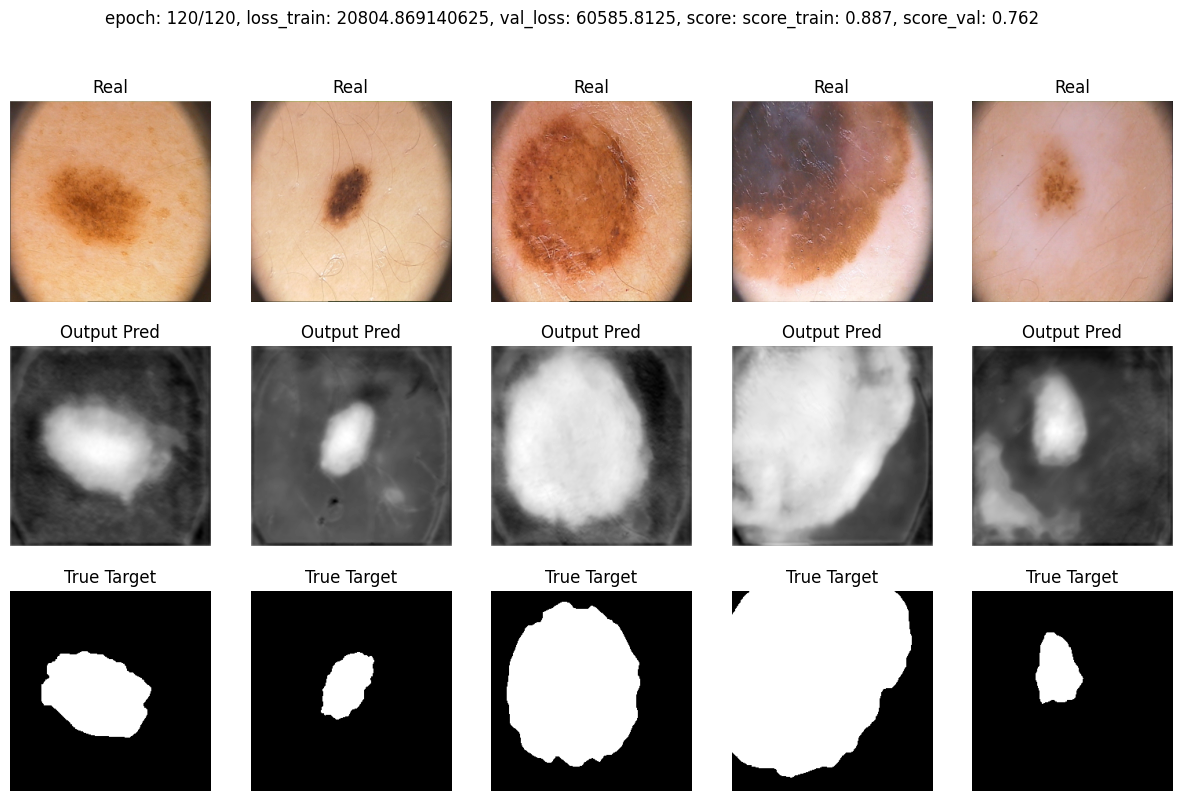

Score by Val Data: 0.7620000123977662
Score by Test Data: 0.7160000205039978


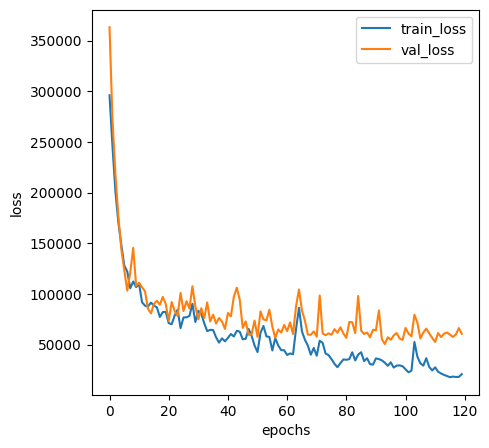

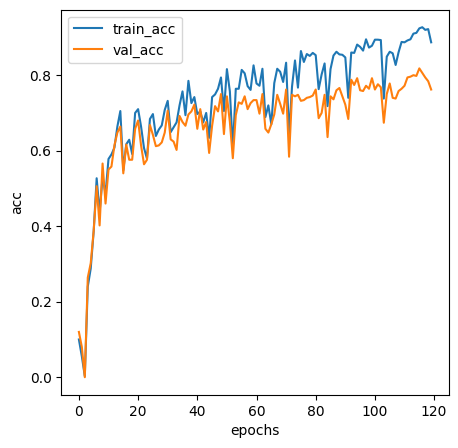

In [163]:
# UNet + Upsampling + bce_loss 120 эпох- 76% размер feature-map вместо 64 всего 8, из-за нехватки памяти видеокарты
model = UNet(channels_size=8).to(device)

max_epochs = 120
optimaizer = optim.Adam(model.parameters())
history = train(model, optimaizer, focal_loss, max_epochs, data_tr, data_val)

score_data_val = score_model(model, iou_pytorch, data_val)
print(f"Score by Val Data: {score_data_val}")
score_data_ts = score_model(model, iou_pytorch, data_ts)
print(f"Score by Test Data: {score_data_ts}")

loss, val_loss, acc, val_acc = zip(*history)
plt.figure(figsize=(5, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


plt.figure(figsize=(5, 5))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

## Отчет

### Графики лосса и скора

#### Seg-Net BCE loss (Score Val: 73,8%, Score Test: 74,4%)
Лосс Seg-Net BCE 120 эпох
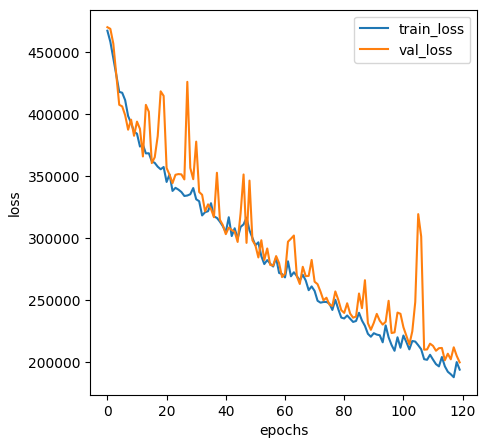
Скор IoU Seg-Net BCE 120 эпох
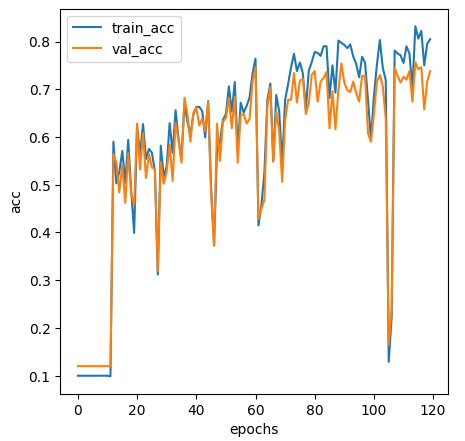


#### Seg-Net Dice loss (Score Val: 78,6% Score Test: 77,6%)
Лосс Seg-Net Dice Loss 120 эпох
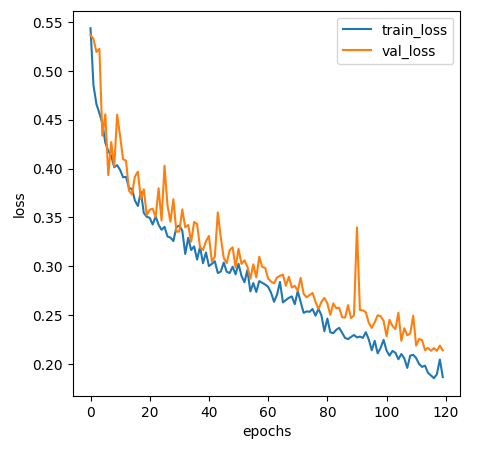
Скор IoU Seg-Net Dice Loss 120 эпох
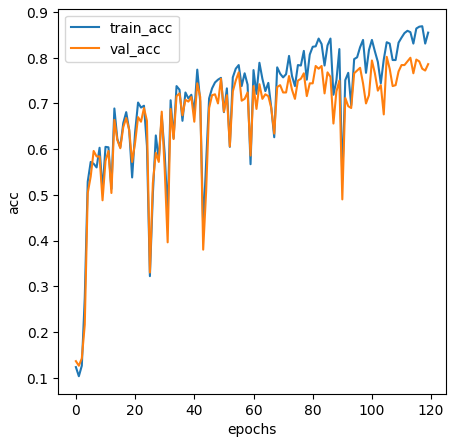

#### Seg-Net Focal loss (Score Val: 72,6% Score Test: 71,8%)
Лосс Seg-Net Focal Loss 120 эпох
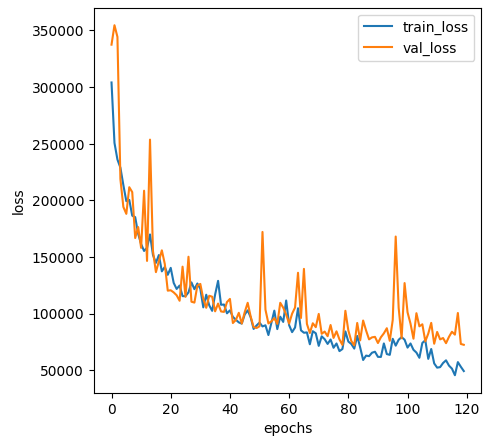
Скор IoU Seg-Net Focal Loss 120 эпох
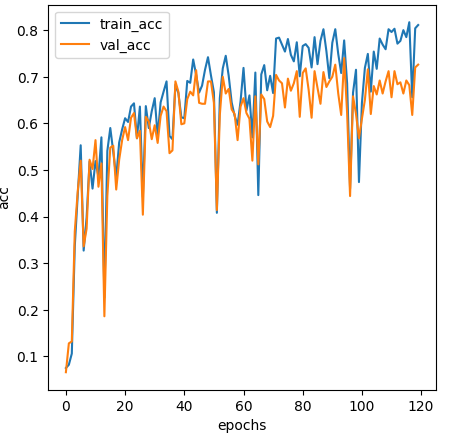


#### Из-за нехватки памяти видеокарты размер каналов (feature-map) используется всего 8 вместо 64 (как в оригинальной U-Net)

#### U-Net BCE (Score Val: 79,2%, Score Test: 73%)
Лосс U-Net на 120 эпохаха с кол-вом базовых каналов 8 вместо 64
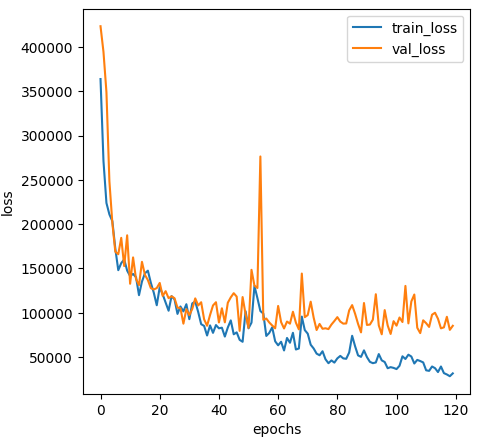
Скор IoU U-Net на 120 эпохаха с кол-вом базовых каналов 8 вместо 64
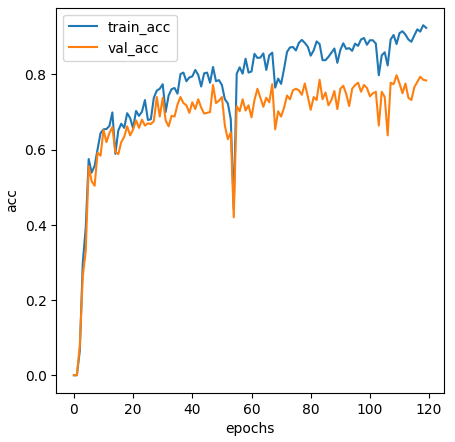

#### U-Net Dice loss (Score Val: 80,8%, Score Test: 75,4%)
Лосс U-Net Dice loss на 120 эпохаха с кол-вом базовых каналов 8 вместо 64
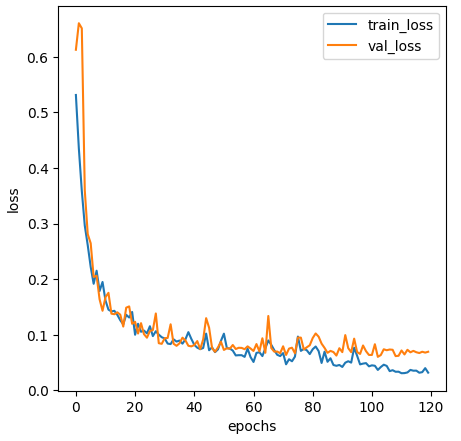
Скор IoU U-Net Dice loss на 120 эпохаха с кол-вом базовых каналов 8 вместо 64
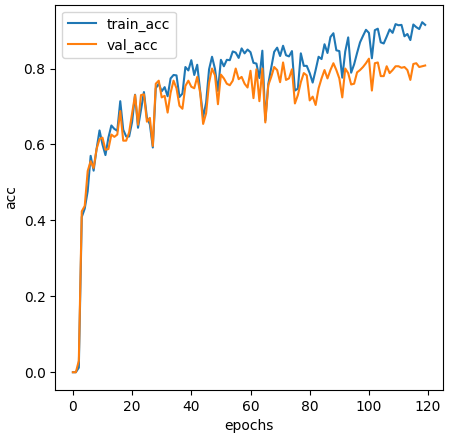

#### U-Net  Focal loss (Score Val: 76,2%, Score Test: 71,6%)
Лосс U-Net Focal loss на 120 эпохаха с кол-вом базовых каналов 8 вместо 64
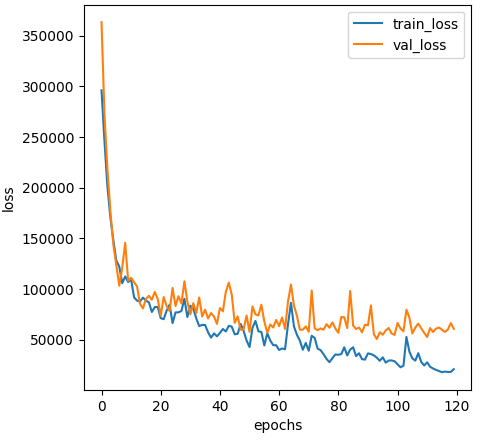
Скор IoU U-Net Focal loss на 120 эпохаха с кол-вом базовых каналов 8 вместо 64
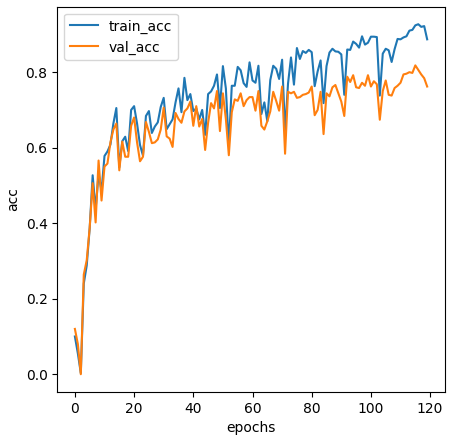

















### Сводная таблица результатов анализа моделей и лоссов

|  Model  | Epoches | LossFunction  |  Loss Train | Loss Val | IoU Score Train | IoU Score Val | IoU Score Test |
|---------|---------|---------------|-------------|----------|-----------------|---------------|----------------|
|Seg-Net  |   120   |  BCE loss     |    >194k    |  >200k   |      80,5%      |     73,8%     |     74,4%      |
|Seg-Net  |   120   |  Dice loss    |    0,19     |  0,21    |      85,5%      |     78,6%     |     77,6%      |
|Seg-Net  |   120   |  Focal loss   |    >49k     |  >72k    |      81,1%      |     72,6%     |     71,8%      |
|U-Net    |   120   |  BCE loss     |    >24k     |  >99k    |      94%        |     79,2%     |     73%        |
|U-Net    |   120   |  Dice loss    |    0,03     |  0,07    |      91,5%      |     80,8%     |     75,4%      |
|U-Net    |   120   |  Focal loss   |    >20k     |  >60k    |      88,7%      |     76,2%     |     71,6%      |



### Выводы:

1. Стоит обратить, что для обучения использовалось довольно мало объектов, всего 100 на обучение (50 на валидацию и 50 на тест) и даже с таким малым размером обучающей выборки, модели смогли достичь уровня точности >78%. В качестве развития можно перераспределить объекты для увеличения обучающей выборки, например 150/25/25.

2. BCE Loss имеет очень высокие веса у (сотни тысяч у Seg-Net и десятки тысяч U-Net), что сказывается на стабильность обучения, это также видно на итоговых графиках - BCE loss имеет больше шума (разброса) в точности и как следствие модель менее стабильная. Использование Focal loss также завышает веса до десятков тысяч. В качестве развития можно применять регуляризацию для ограничения роста весов. Лучше всех показала себя функция Dice loss, у которой веса не превышали 1 и с этим лосом графики скора и лосса были более стабильны.

3. В целом U-Net показывает более стабильные графики лосса и скора, также U-Net держит значение лосса гораздо ниже чем Seg-Net, это говорит о том, что модель U-Net более стабильная. 

4. Из-за нехватки памяти видеокарты размер каналов (feature-map) используется всего 8 вместо 64 (как в оригинальной U-Net). Однако точность при этом остается на достаточно высоком уровне. Это также повлияло на скорорсть обучения U-Net заметно быстрее обучается.

5. Наивысшую точность на тестовых данных удалось достичь на Seg-Net (Dice Loss) - 77,6% и U-Net (Dice Loss) - 75,4%. Однако выбирая модель для дальнейшего решения задачи, лучше подойдет U-Net из-за своей стабильности в решении (меньше разброс в графиках лосса и скора), а также лучшего подбора весов (сильно меньше чем у Seg-Net).

6. Во все моедли внедрено управление базовым кол-вом каналов (по умолчанию channels_size=64), это позволяет выбрать оптимальное значение при отсутствии болшого кол-ва видеопамяти

7. При каждому обучении history фиксирует не только loss но и score по каждой эпохе, это позволяет сразу же выводить графики лоса и точности для трайна и валидации. Также в итоге выводится скор по тестовой выборке.

8. Судя по результатам score и loss модели не переобучаются даже при исползовании 120 эпох, однако замедление роста качества. В целях развития можно увеличить число эпох.

9. Добавление в Dice loss сигмоиды позволило улучшить результат работы сетки (мы и так предсказывали принадлежность пикселей от 0 до 1, поэтому сигмоида позволила убрать отрицательные значения и вообще норм стало). Важно! Это только при проверке лосса делается а выходной слой не трогается

10. В качестве развития также можно увеличить размер картинок используемых для обучения, сейчас идет ресайз на 255х255, однако самый минимальный общий размер к которому можно привести все изображения составляет 553х761 (т.е. размер изображений можно безболезнено увеличить в два раза). Это также позволит повысит точность моделей, но потребует дополнительных ресурсов.


